In [1]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io
from xdgmm import XDGMM as XDGMM_Holoien

# cmass_st82 = use this instead
prob_st82 = fitsio.read('../output/test/train_cat/y3/dmass_st82_part1.fits')
dmass_st82 = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/matched_cmass.fits')

#dmass_spt = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/dmass_sys_weight_pca_ALL.fits')

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# NOW WITH REAL SPT

#input_path = '/fs/scratch/PCON0008/warner785/bwarner/'
#input_keyword = 'dmass_spt_'  
#dmass_spt = io.SearchAndCallFits(path = input_path, keyword = input_keyword)



Calling catalogs >>>
dmass_spt_5.fits
dmass_spt_2.fits
dmass_spt_4.fits
dmass_spt_8.fits
dmass_spt_9.fits
dmass_spt_1.fits
dmass_spt_3.fits
dmass_spt_7.fits
dmass_spt_0.fits
dmass_spt_6.fits
reading 1/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_5.fits
reading 2/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_2.fits
reading 3/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_4.fits
reading 4/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_8.fits
reading 5/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_9.fits
reading 6/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_1.fits
reading 7/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_3.fits
reading 8/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_7.fits
reading 9/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_0.fits
reading 10/10 /fs/scratch/PCON0008/warner785/bwarner/dmass_spt_6.fits


In [3]:
# save spt region

outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_spt.fits', dmass_spt, overwrite=True)

In [4]:
# no systematic weights for now:

w_dmass_initial = np.full(len(dmass_spt['CMASS_PROB']), 1)
dmass_spt = appendColumn(dmass_spt, name='SYS_WEIGHT', value= w_dmass_initial)

In [5]:
mg1, mg2, _ = esutil.htm.HTM(10).match(dmass_st82['RA'], dmass_st82['DEC'], prob_st82['RA'], \
                                         prob_st82['DEC'],2./3600, maxmatch=1)
cmass_mask = np.zeros(prob_st82.size, dtype=bool)
cmass_mask[mg2] = 1
clean_cmass_data_des, nocmass = prob_st82[cmass_mask], prob_st82[~cmass_mask]

clean_cmass_data_sdss = dmass_st82[mg1]
print(clean_cmass_data_sdss.size)

20654


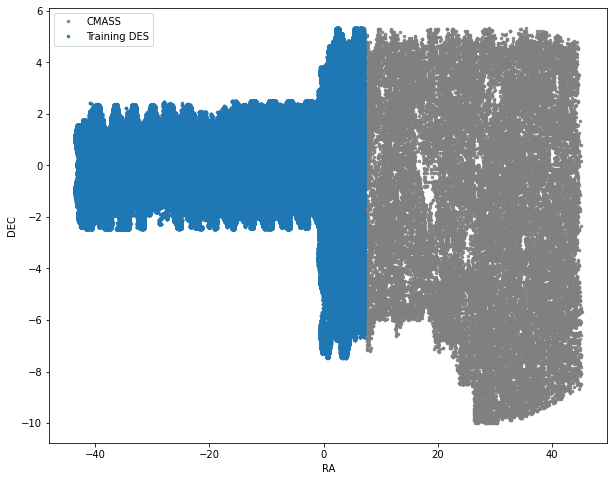

In [6]:
#check spt fits file:
spatialcheck([dmass_st82, prob_st82], 
             label = ['CMASS', 'Training DES'], convert = None, ratag='RA',dectag='DEC')

In [7]:
dmass_st82 = clean_cmass_data_des

0 14.40398954197734
1 9.528420644911398
2 8.42935993027985
3 8.027500726251574
4 8.279267938413867
5 8.923211000290502
6 9.04425292921468
7 10.259513895613441
8 11.891159097511379
9 11.213324295535973


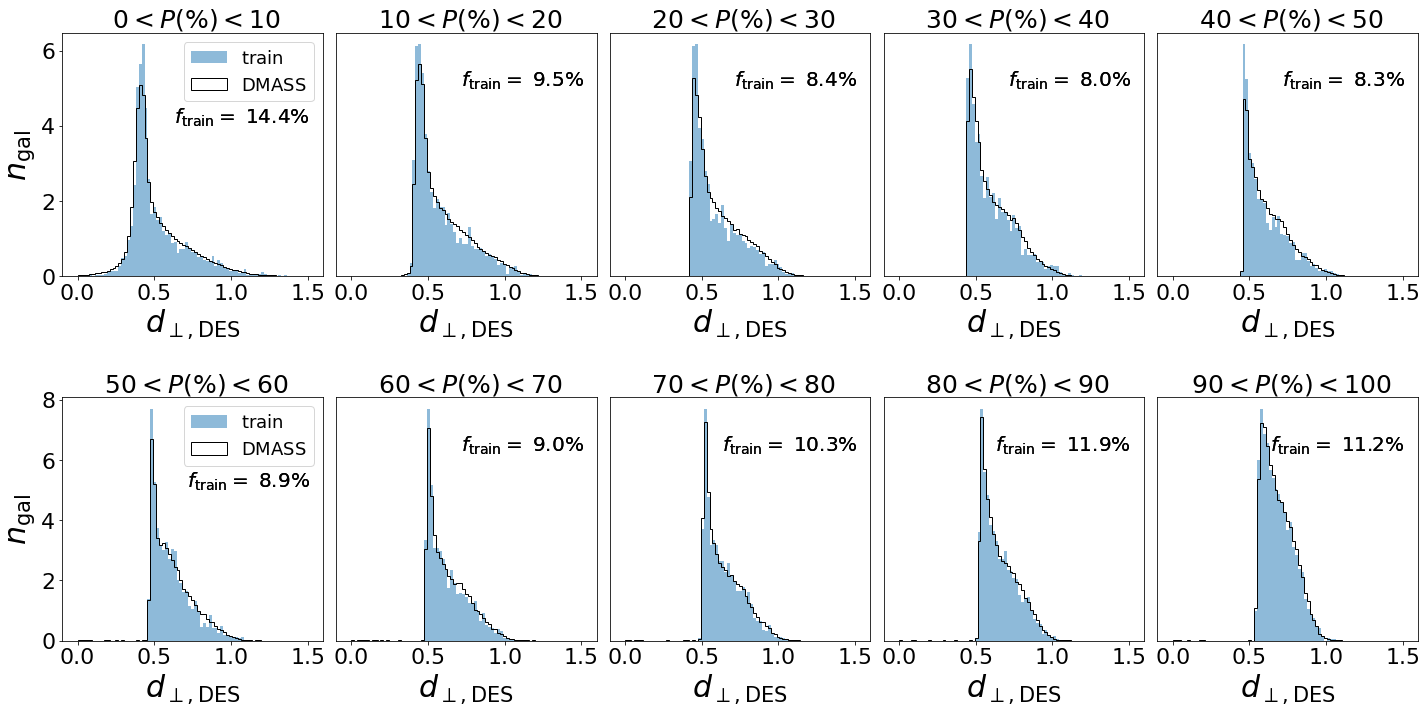

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

probcut = 0.0
np.linspace(0.0, 1.5, 6)

labels = [r'${\rm train}$', r'${\rm DMASS}$']
catlist = [dmass_st82, dmass_spt[dmass_spt['CMASS_PROB']>0.00]]
cbin = np.linspace(0.,1.5, 80)
probcut = 0
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.ravel()

for i in range(10):  
    for la, cat in zip(labels, catlist) :     
        mask = (cat['CMASS_PROB'] > probcut) & (cat['CMASS_PROB'] < probcut + 0.1) \
        & (cat['CMASS_PROB'] > 0.00) # & ( (cat['MAG_MODEL_G']- cat['MAG_MODEL_R']) < 1.6)
        
        histtype = 'stepfilled'
        alpha = 0.5
        if la == r'${\rm DMASS}$' : 
            Nhist, _,_ = ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density= True, alpha = 1.0, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                       histtype='step', color = 'black', weights = cat[mask]['CMASS_PROB']*cat[mask]['SYS_WEIGHT']);  
        
        else : 
            Nhist2, _, _=ax[i].hist( (cat['MAG_DETMODEL_R']-cat['MAG_DETMODEL_I']- (cat['MAG_DETMODEL_G']-cat['MAG_DETMODEL_R'])/8.)[mask], \
                    bins = cbin, density = True, alpha = alpha, label = la + ''.format(np.sum(mask)*1./mask.size*100), \
                     histtype=histtype); 
            fraction_train = np.sum(mask)*1./mask.size*100
            print(i, fraction_train)
            
        #print probcut, probcut+0.1, np.sum(mask), la
        #print i,
        tag = r' ${:0.0f} < P(\%) < {:0.0f}$'.format(probcut*100, probcut*100+10)
        
        #ax[i].set_xlim(0, 1.0)
        if i in [0, 5]: 
            ax[i].legend(loc=1, fontsize = 18)
            ax[i].set_ylabel(r'$n_{\rm gal}$', fontsize = 30)
            
#            ax[i].set_yticks([0, max(Nhist.max(), Nhist2.max())])
#            ax[i].set_yticklabels(['$0$', '$1$'])
            ax[i].text(0.95, 0.7, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        else : 
            #pass
            ax[i].get_yaxis().set_visible(False)
            ax[i].text(0.95, 0.85, r'$f_{\rm train}=$'+'$~{:0.1f}\%$'.format(fraction_train), 
                   fontsize = 20, ha='right', va='top', transform=ax[i].transAxes)
        ax[i].set_title(tag, fontsize=25)
        ax[i].set_xlabel(r'$d_{\perp, {\rm DES}}$', fontsize = 30)
        ax[i].set_xlim(-0.1, 1.6)
        ax[i].set_xticks(np.linspace(0.0, 1.5, 4))
        #ax[i].set_xticklabels(np.linspace(0.0, 1.5, 6))
        #ax[i].set_ylabel(r'$n(z)$')
        #ax[i].get_yaxis().set_visible(False)
        ax[i].tick_params(labelsize = 22)
        #ax[i].set_ylim(0,7)
        
        #ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #elif i != 2 : ax[i].get_yaxis().set_visible(False)
        
    probcut += 0.1
    
#ax[0].get_yaxis().set_visible(True)
#ax[5].get_yaxis().set_visible(True)


fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.5);

In [9]:
# Figure 5:

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io
from xdgmm import XDGMM as XDGMM_Holoien

In [10]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [11]:
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0008/warner785/bwarner/gold_full/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'gold_st82_final'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]


Calling catalogs >>>
gold_st82_final_000056.fits
gold_st82_final_000003.fits
gold_st82_final_000026.fits
gold_st82_final_000121.fits
gold_st82_final_000094.fits
gold_st82_final_000040.fits
gold_st82_final_000010.fits
gold_st82_final_000082.fits
gold_st82_final_000068.fits
gold_st82_final_000075.fits
gold_st82_final_000103.fits
gold_st82_final_000112.fits
gold_st82_final_000043.fits
gold_st82_final_000125.fits
gold_st82_final_000083.fits
gold_st82_final_000101.fits
gold_st82_final_000016.fits
gold_st82_final_000031.fits
gold_st82_final_000041.fits
gold_st82_final_000052.fits
gold_st82_final_000092.fits
gold_st82_final_000027.fits
gold_st82_final_000127.fits
gold_st82_final_000095.fits
gold_st82_final_000114.fits
gold_st82_final_000079.fits
gold_st82_final_000045.fits
gold_st82_final_000086.fits
gold_st82_final_000007.fits
gold_st82_final_000029.fits
gold_st82_final_000055.fits
gold_st82_final_000076.fits
gold_st82_final_000069.fits
gold_st82_final_000105.fits
gold_st82_final_000100.fit

In [12]:
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
6860133
5752145


In [13]:
mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)|(gold_st82['RA']<7)
mask = mask & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)
#gold_train_random_ind = np.random.choice(np.arange(gold_st82_train.size), size = int(gold_st82_train.size/5))
#gold_train_random = gold_st82_train[gold_train_random_ind]
#print(gold_train_random.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

clf_200 = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_final2.xdgmm')
clf_no200 = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_final2.xdgmm')
X_sample_dmass = clf_200.sample(200000)        # non-cmass model
X_sample_nodmass = clf_no200.sample(200000)

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

1855129


In [14]:
def doVisualization_1d( data=None, labels = None, 
ranges = None, name = None, weight = [None,None], 
color=['grey', 'tab:blue', 'tab:orange', 'tab:green'],
nbins=100, filename=None):


    if labels == None:
        print(" always label your axes! you must populate the 'labels' keyword with one entry for each dimension of the data.")
        stop
    else:
        ndim = len(labels)
    
    if ranges == None:
        # try to figure out the correct axis ranges.
        print("Using central 100% to set range.")
        ranges = []
        for i in range(ndim):
            ranges.append( np.percentile(data[-1][:,i],[0.,100.]) )

    
    fig,axes = plt.subplots(nrows=1, ncols= ndim, figsize= (4*ndim, 4) )
    #print weight[0], weight[1].size, data1[:,0].size 
    for i in range(ndim):
        xbins = np.linspace(ranges[i][0],ranges[i][1], nbins)
        for j in range(len(data)):    
            if j == 1:
                axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.8, color =color[j], density=True, histtype='step')
            else:
                axes[i].hist(data[j][:,i],bins=xbins, label=name[j], weights=weight[j], alpha = 0.5, color =color[j], density=True)
            #axes[i].hist(data[:,i],bins=xbins, alpha=1.0,label=name[1], weights=weight[1], histtype='step', color='k', lw=1, density=True)
        axes[i].set_xlabel(labels[i], fontsize = 20)
        #axes[i].hist(data2[:,i],bins=xbins,normed=True,alpha=0.5,label='data2')
        axes[i].get_yaxis().set_visible(False)
        axes[i].tick_params(labelsize=15)
        axes[i].legend(loc='best',fontsize = 10)

    #filename = "figure/diagnostic_histograms_1d.pdf"
    #print("writing output plot to: "+filename)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5);
    if filename != None: fig.savefig(filename)
    #plt.close(fig)


In [16]:
def mixing_color(data, suffix = '', 
    mag = ['MAG_DETMODEL', 'MAG_DETMODEL'], 
    err = [ 'MAGERR_DETMODEL','MAGERR_DETMODEL'], 
    filter = ['G', 'R', 'I'],
    sdss = None, cmass = None, elg=None,
    no_zband = True  ):
    
    magtag = [ m+'_'+f+suffix for m in mag for f in filter ]
    errtag = [ e+'_'+f for e in err for f in filter ]
    del magtag[0], errtag[0]
    if 'Z' in filter: del magtag[2], errtag[2]
    #print(magtag)

    X = [ data[mt] for mt in magtag ]
    Xerr = [ data[mt] for mt in errtag ]
    #reddeningtag = 'XCORR_SFD98'

    X = np.vstack(X).T
    Xerr = np.vstack(Xerr).T
    # mixing matrix
    W = np.array([
                  [1, 0, 0, 0, 0, 0],    # r mag
                  [0, 1, 0, 0, 0, 0],    # i mag
                  [0, 0, 1, -1, 0, 0],   # g-r
                  [0, 0, 0, 1, -1, 0],   # r-i
                  [0, 0, 0, 0, 1, -1]])  # i-z

    if 'Z' not in filter: W = W[:-1,:-1]
    X = np.dot(X, W.T)

    Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
    Xcov[:, list(range(Xerr.shape[1])), list(range(Xerr.shape[1]))] = Xerr**2
    Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))
    return X, Xcov


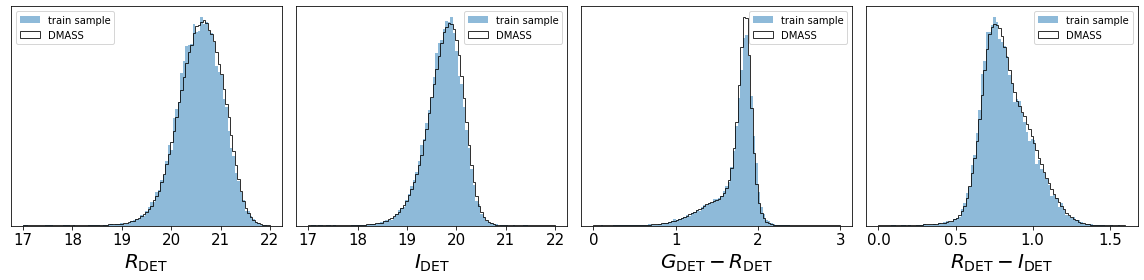

In [17]:
#dmass_spt = fitsio.read('../output/test/train_cat/y3/dmass_sys_weight_val_FULL_lin.fits')

weights = dmass_spt['CMASS_PROB'] * dmass_spt['SYS_WEIGHT']
X_dmass,_ = mixing_color(dmass_spt)

# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_dmass], 
                   labels = [r'${R_{\rm DET}}$', r'${I_{\rm DET}}$', r'$G_{\rm DET}-R_{\rm DET}$', r'$R_{\rm DET}-I_{\rm DET}$'], 
                   ranges = [(17,22),(17,22),(0,3),(0.0,1.6)], 
                   name = ['train sample', 'DMASS'], 
                   weight = [None,weights], 
                   color = ['tab:blue','black'],
                   nbins=100, filename = 'SPT_cmass.pdf')